In [596]:
BATCH_SIZE=16
import tqdm
for _ in tqdm.tqdm(range(900)):
  for _ in range(30):
    
    #generators
    
    gen_opt.zero_grad()
    
    noise = make_batch_radio()
    fakes = genA(noise)
    scores = discA(warping(fakes))

    #genA_loss = torch.mean(F.softplus(-scores))
    genA_loss = torch.mean((1 - scores)**2)
    noise = make_batch_dxa()
    fakes = genB(noise)
    scores = discB(warping(fakes))

    #genB_loss = torch.mean(F.softplus(-scores))
    genB_loss = torch.mean((1 - scores)**2)
    start = make_batch_radio()
    end = genB(genA(start))
    
    cycle1 = torch.mean(torch.abs(start - end))
    
    start = make_batch_dxa()
    end = genA(genB(start))
    
    cycle2 = torch.mean(torch.abs(start - end))
    
   
    ((genA_loss + genB_loss) + 10 * (cycle1 + cycle2)).backward()
    gen_opt.step()
    
    
    disc_opt.zero_grad()
    
    noise = make_batch_radio()
    fakes = genA(noise)
    batch = warping(nogen(make_batch_dxa()))
    batch.requires_grad=True

    
    scores_real = torch.mean(discA(batch), [1, 2, 3])
    scores_fake = torch.mean(discA(warping(fakes)), [1, 2, 3])


    score_gradient = torch.autograd.grad(
        scores_real, batch, torch.ones(scores_real.shape, device='cuda'), create_graph=True)

    #discA_loss = torch.mean(F.softplus(scores_fake)) + torch.mean(F.softplus(-scores_real)) 
    discA_loss = torch.mean((scores_fake)**2) + torch.mean((1 - scores_real)**2)

    discA_penalty = torch.sum((score_gradient[0])**2) / BATCH_SIZE
    
    

    noise = make_batch_dxa()
    fakes = genB(noise)
    batch = warping(nogen(make_batch_radio()))
    batch.requires_grad=True

    
    scores_real = torch.mean(discB(batch), [1, 2, 3])
    scores_fake = torch.mean(discB(warping(fakes)), [1, 2, 3])


    score_gradient = torch.autograd.grad(
        scores_real, batch, torch.ones(scores_real.shape, device='cuda'), create_graph=True)

    #discB_loss = torch.mean(F.softplus(scores_fake)) + torch.mean(F.softplus(-scores_real))
    discB_loss = torch.mean((scores_fake)**2) + torch.mean((1 - scores_real)**2)
    discB_penalty = torch.sum((score_gradient[0])**2) / BATCH_SIZE
    
    (discA_loss + 7 * discA_penalty + discB_loss + 7 * discB_penalty).backward()
    disc_opt.step()
    
    gal += [genA_loss.item()]
    gbl += [genB_loss.item()]
    c1 += [cycle1.item()]
    c2 += [cycle2.item()]

    da1 += [discA_loss.item()]
    dbl += [discB_loss.item()]
    dap += [discA_penalty.item()]
    dbp += [discB_penalty.item()]
    

  2%|█▉                                                                                                    | 17/900 [03:32<3:04:18, 12.52s/it]


KeyboardInterrupt: 

In [2]:
import preprocess_data
import random
import torch
import matplotlib.pyplot as plt
dxa, _ = preprocess_data.dxa_dataset()
radio, _ = preprocess_data.radiograph_dataset()

GDCMImageIO (0x56343619b600): Converting from MONOCHROME1 to MONOCHROME2 may impact the meaning of DICOM attributes related to pixel values.

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


In [3]:
N = 0

In [4]:
def show(im):
    plt.imshow(im.detach().cpu(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()
    
def check(A, B):
    plt.imshow(itk.checker_board_image_filter(
        A.detach().cpu().numpy(),
        B.detach().cpu().numpy(),
        checker_pattern=9
    ))

In [406]:

def warping(tensor):
    identity = torch.Tensor([[[1., 0, 0], [0, 1, 0], [0, 0, 1]]]).cuda()
    mask = torch.Tensor([[[1., 1, 1], [1, 1, 1], [0, 0, 0]]]).cuda()
    noise = torch.randn((tensor.shape[0], 3, 3)).cuda()

    forward = identity + .075 * noise * mask


    forward_grid = F.affine_grid(forward[:, :2], tensor[:, :3].shape)
    
    warped_input = F.grid_sample(tensor, forward_grid)
    
    return warped_input

def apply_warped(net, tensor):
    identity = torch.Tensor([[[1., 0, 0], [0, 1, 0], [0, 0, 1]]]).cuda()
    mask = torch.Tensor([[[1., 1, 1], [1, 1, 1], [0, 0, 0]]]).cuda()
    noise = torch.randn((tensor.shape[0], 3, 3)).cuda()

    forward = identity + .075 * noise * mask

    backward = torch.inverse(forward)
    
    if random.random() < .5:
        forward, backward = backward, forward

    forward_grid = F.affine_grid(forward[:, :2], tensor[:, :3].shape)
   
    
    warped_input = F.grid_sample(tensor, forward_grid)
    
    warped_output = net(warped_input)
    
    backward_grid = F.affine_grid(backward[:, :2], warped_output.shape)
    
    unwarped_output = F.grid_sample(warped_output, backward_grid)
    
    return unwarped_output

In [603]:
dxa_s = dxa[:, :, ::4, ::4]
radio_s = radio[:, :, ::4, ::4]

def make_batch():
    idx_dxa = range(len(dxa))
    idx_radio = range(len(radio))
    imgs = [
        dxa_s[random.choice(idx_dxa)][None] if (random.random() > .5) 
        else torch.flip(radio_s[random.choice(idx_radio)][None], dims=(3,))
        for i in range(BATCH_SIZE)
    ]
    return torch.cat(imgs).cuda().float()

def make_double_batch():
    
    is_dxa = [random.random() > .5 for i in range(BATCH_SIZE)]
    
    idx_dxa = range(len(dxa))
    idx_radio = range(len(radio))
    
    imgs1 = [
        dxa_s[random.choice(idx_dxa)][None] if is_dxa[i] 
        else torch.flip(radio_s[random.choice(idx_radio)][None], dims=(3,))
        for i in range(BATCH_SIZE)
    ]
    
    imgs2 = [
        dxa_s[random.choice(idx_dxa)][None] if is_dxa[i] 
        else torch.flip(radio_s[random.choice(idx_radio)][None], dims=(3,))
        for i in range(BATCH_SIZE)
    ]
    
    
    return torch.cat(imgs1).cuda().float(), torch.cat(imgs2).cuda().float()
def make_batch_radio():
    idx_radio = range(len(radio))
    imgs = [
        torch.flip(radio_s[random.choice(idx_radio)][None], dims=(3,))
        for i in range(BATCH_SIZE)
    ]
    return torch.cat(imgs).cuda().float()

def make_batch_dxa():
    idx_dxa = range(len(dxa))
    imgs = [
        dxa_s[random.choice(idx_dxa)][None]
        for i in range(BATCH_SIZE)
    ]
    return torch.cat(imgs).cuda().float()

In [604]:
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, num_layers, channels, dimension):
        super().__init__()

        self.num_layers = num_layers
        down_channels = np.array(channels[0])
        up_channels_out = np.array(channels[1][1:])
        up_channels_in = down_channels[1:] + np.concatenate([up_channels_out[1:], [0]])
        self.downConvs = nn.ModuleList([])
        self.upConvs = nn.ModuleList([])

        for depth in range(self.num_layers):
            self.downConvs.append(
                nn.Conv2d(
                    down_channels[depth],
                    down_channels[depth + 1],
                    kernel_size=3,
                    padding=1,
                    stride=2,
                )
            )
            self.upConvs.append(
                nn.ConvTranspose2d(
                    up_channels_in[depth],
                    up_channels_out[depth],
                    kernel_size=4,
                    padding=1,
                    stride=2,
                )
            )

        self.lastConv = nn.Conv2d(17, channels[1][0], kernel_size=3, padding=1)

    def forward(self, x):
        skips = []
        for depth in range(self.num_layers):
            skips.append(x)
            x = F.gelu(self.downConvs[depth](x))
        for depth in reversed(range(self.num_layers)):
            x = F.gelu(self.upConvs[depth](x))

            x = x[:, :, : skips[depth].size()[2], : skips[depth].size()[3]]
            x = torch.cat([x, skips[depth]], 1)
        x = self.lastConv(x)
        return x 

genA = UNet(6, [[1, 16, 32, 64, 128, 128, 128], [1, 16, 32, 64, 128, 128, 128]], 2)
discA = UNet(6, [[1, 16, 32, 32, 32, 32, 64], [1, 16, 32, 32, 32, 32, 64]], 2)

genB = UNet(6, [[1, 16, 32, 64, 128, 128, 128], [1, 16, 32, 64, 128, 128, 128]], 2)
discB = UNet(6, [[1, 16, 32, 32, 32, 32, 64], [1, 16, 32, 32, 32, 32, 64]], 2)

class Identity(torch.nn.Module):
    def forward(self, x):
        return x
    
class WarpedNetwork(torch.nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
    def forward(self, x):
        return apply_warped(self.net, x)
    
nogen = WarpedNetwork(Identity())
genA = WarpedNetwork(genA)
genB = WarpedNetwork(genB)


In [605]:


genA.cuda()
discA.cuda()
genB.cuda()
discB.cuda()

gen_opt = torch.optim.Adam(list(genA.parameters()) + list(genB.parameters()), lr=1e-4, betas=(0, .9))
disc_opt = torch.optim.Adam(list(discA.parameters()) + list(discB.parameters()), lr=1e-3, betas=(0, .9))
gen_loss_list = []
disc_loss_list = []

disc_penalty_list = []




gal = []
gbl = []
c1 = []
c2 = []

da1 = []
dbl = []
dap = []
dbp = []

In [681]:
BATCH_SIZE=16
import tqdm
for _ in tqdm.tqdm(range(100)):
  for _ in range(30):
    
    #generators
    
    gen_opt.zero_grad()
    
    noise = make_batch_radio()
    fakes = genA(noise)
    scores = discA(warping(fakes))

    genA_loss = torch.mean(F.softplus(-scores))
    
    noise = make_batch_dxa()
    fakes = genB(noise)
    scores = discB(warping(fakes))

    genB_loss = torch.mean(F.softplus(-scores))
    
    start = make_batch_radio()
    end = genB(genA(start))
    
    cycle1 = torch.mean(torch.abs(start - end))
    
    start = make_batch_dxa()
    end = genA(genB(start))
    
    cycle2 = torch.mean(torch.abs(start - end))
    
   
    (.3 * (genA_loss + genB_loss) + 300 * (cycle1 + cycle2)).backward()
    gen_opt.step()
    
    
    disc_opt.zero_grad()
    
    noise = make_batch_radio()
    fakes = genA(noise)
    batch = warping(nogen(make_batch_dxa()))
    batch.requires_grad=True

    
    scores_real = torch.mean(discA(batch), [1, 2, 3])
    scores_fake = torch.mean(discA(warping(fakes)), [1, 2, 3])


    score_gradient = torch.autograd.grad(
        scores_real, batch, torch.ones(scores_real.shape, device='cuda'), create_graph=True)

    discA_loss = torch.mean(F.softplus(scores_fake)) + torch.mean(F.softplus(-scores_real)) 
    discA_penalty = torch.sum((score_gradient[0])**2) / BATCH_SIZE
    
    

    noise = make_batch_dxa()
    fakes = genB(noise)
    batch = warping(nogen(make_batch_radio()))
    batch.requires_grad=True

    
    scores_real = torch.mean(discB(batch), [1, 2, 3])
    scores_fake = torch.mean(discB(warping(fakes)), [1, 2, 3])


    score_gradient = torch.autograd.grad(
        scores_real, batch, torch.ones(scores_real.shape, device='cuda'), create_graph=True)

    discB_loss = torch.mean(F.softplus(scores_fake)) + torch.mean(F.softplus(-scores_real)) 
    discB_penalty = torch.sum((score_gradient[0])**2) / BATCH_SIZE
    
    (discA_loss + discA_penalty + discB_loss + discB_penalty).backward()
    disc_opt.step()
    
    gal += [genA_loss.item()]
    gbl += [genB_loss.item()]
    c1 += [cycle1.item()]
    c2 += [cycle2.item()]

    da1 += [discA_loss.item()]
    dbl += [discB_loss.item()]
    dap += [discA_penalty.item()]
    dbp += [discB_penalty.item()]
    
  
    

 36%|█████████████████████████████████████▍                                                                  | 36/100 [07:25<13:11, 12.36s/it]


KeyboardInterrupt: 

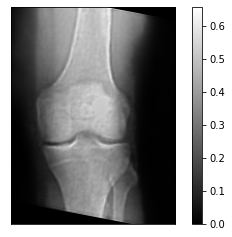

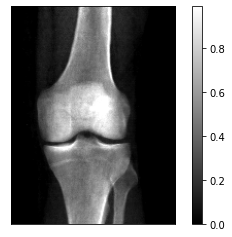

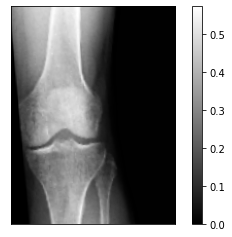

In [682]:
N += 1
N %= 16
show(fakes[N, 0])
show(noise[N, 0])
show(batch[N, 0])

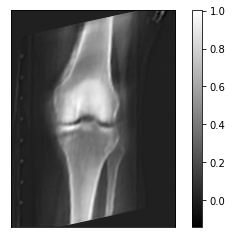

In [684]:
show(genA(make_batch_radio())[3, 0])


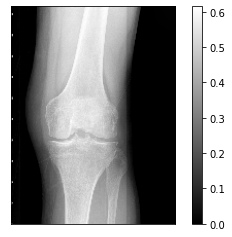

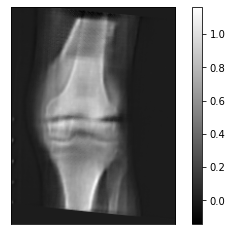

In [698]:
rad = make_batch_radio()
show(rad[0, 0])

show(genA(rad)[0, 0])

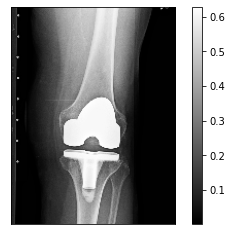

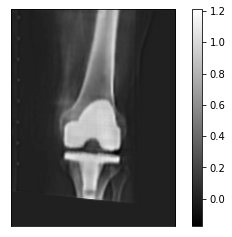

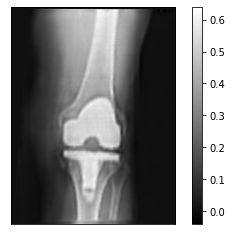

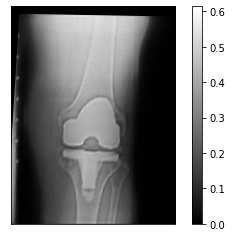

In [674]:
rad = make_batch_radio()
show(rad[0, 0])
show(genA(rad)[0, 0])
show(genB(genA(rad))[0, 0])
show(genB(rad)[0, 0])

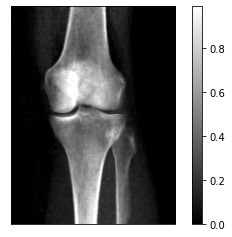

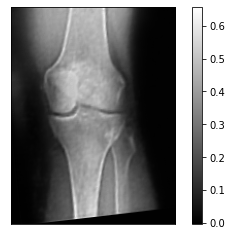

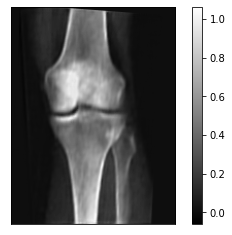

In [675]:
d = make_batch_dxa()
show(d[0, 0])
show(genB(d)[0, 0])
show(genA(genB(d))[0, 0])

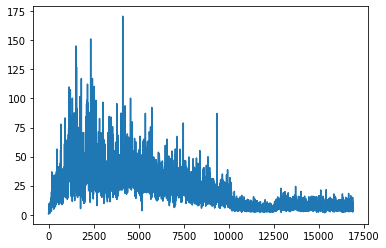

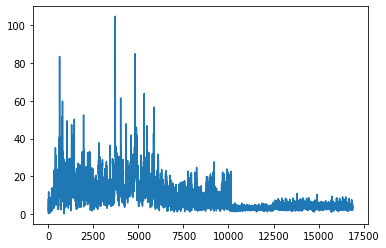

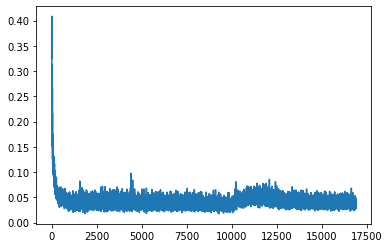

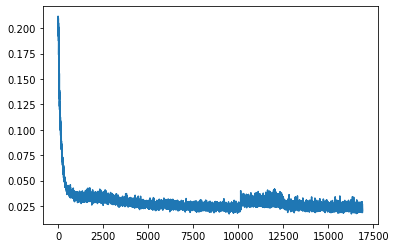

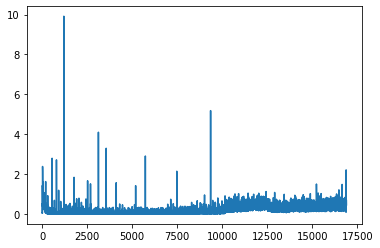

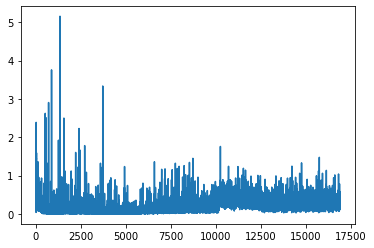

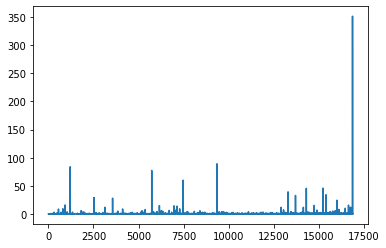

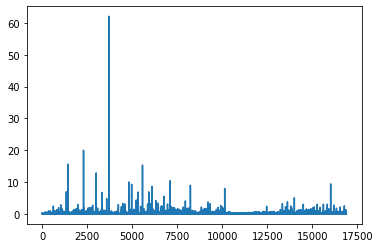

In [676]:
for loss in (gal,gbl,c1,c2,da1,dbl,dap,dbp ):
    plt.plot(loss)
    plt.show()

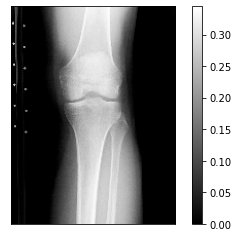

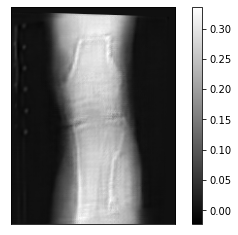

In [679]:
show(start[0, 0])
show(end[0, 0])

In [317]:
torch.save(radio_s, "/playpen/tgreer/radio_dataset")

In [678]:
start = make_batch_radio()
end = genB(genA(start))

In [568]:
scores_fake

tensor([-0.0050, -0.0011, -0.0071, -0.0011, -0.0033, -0.0061,  0.0028, -0.0051,
         0.0121, -0.0033, -0.0047, -0.0068, -0.0038,  0.0121, -0.0002, -0.0020],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [569]:
scores_real

tensor([0.9217, 0.9835, 0.9585, 0.9928, 0.9661, 0.9425, 0.9855, 0.9387, 0.9629,
        0.9540, 0.9577, 0.9872, 0.9674, 0.9344, 0.9611, 0.9819],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [701]:
torch.save({"genA":genA.state_dict(), "genB":genB.state_dict(), "discA":discA.state_dict(), "discB":discB.state_dict}, footsteps.output_dir + "best_cyclegan")

Input name of experiment:
cyclegan_attempt
Saving results to results/cyclegan_attempt/


In [700]:
import footsteps

In [ ]:
cp cyclegan.ipynb results/